# LSTM model (long short term memory)

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             roc_auc_score, log_loss, matthews_corrcoef, balanced_accuracy_score, 
                             cohen_kappa_score, confusion_matrix)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [46]:
df = pd.read_csv('dataset.csv')

C:\Users\raksh\AppData\Local\Temp\ipykernel_20064\112859877.py:1: DtypeWarning: Columns (22,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('dataset.csv')


In [47]:
def get_engine_status(row):
    # Get DTC_NUMBER and Trouble_codes as strings (handle missing values)
    dtc = str(row['DTC_NUMBER']).strip() if pd.notnull(row['DTC_NUMBER']) else ""
    tc = str(row['TROUBLE_CODES']).strip() if pd.notnull(row['TROUBLE_CODES']) else ""
    # Rule:
    # If DTC_NUMBER equals "MIL is OFF1" OR Trouble_codes is nonblank and starts with "P", then malfunctioning.
    if dtc == "MIL is OFF1" or (tc != "" and tc.upper().startswith("P")):
        return 1  # malfunctioning
    else:
        return 0  # healthy

In [48]:
cols_to_drop = [
    'AUTOMATIC', 'BAROMETRIC_PRESSURE(KPA)', 'FUEL_LEVEL', 'AMBIENT_AIR_TEMP', 
    'INTAKE_MANIFOLD_PRESSURE', 'MAF', 'LONG TERM FUEL TRIM BANK 2', 'FUEL_TYPE', 
    'FUEL_PRESSURE', 'SHORT TERM FUEL TRIM BANK 2', 'ENGINE_RUNTIME', 
    'EQUIV_RATIO', 'TIMESTAMP', 'VEHICLE_ID'
]
df.drop(columns=cols_to_drop, errors='ignore', inplace=True)

In [49]:
feature_cols = [
    'MARK', 'MODEL', 'CAR_YEAR', 'ENGINE_POWER', 'ENGINE_COOLANT_TEMP', 
    'ENGINE_LOAD', 'ENGINE_RPM', 'AIR_INTAKE_TEMP', 'SPEED', 
    'SHORT TERM FUEL TRIM BANK 1', 'THROTTLE_POS', 'TIMING_ADVANCE', 
    'MIN', 'HOURS', 'DAYS_OF_WEEK', 'MONTHS', 'YEAR'
]
df_model = df[ feature_cols + ['DTC_NUMBER', 'TROUBLE_CODES'] ].copy()
df_model['EngineStatus'] = df_model.apply(get_engine_status, axis=1)

# df_model.dropna(subset=['EngineStatus'], inplace=True) # drop rows with missing EngineStatus

In [50]:
X = df_model[feature_cols]
y = df_model['EngineStatus']

In [52]:
meta_info = df_model[['DTC_NUMBER', 'TROUBLE_CODES']]

In [53]:
# preprocess the data - preprocessing pipeline
categorical_features = ['MARK', 'MODEL']
numeric_features = [col for col in feature_cols if col not in categorical_features]
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [59]:
# Split into Training and Test Sets
X_train, X_test, y_train, y_test, meta_train, meta_test = train_test_split(
    X, y, meta_info, test_size=0.2, random_state=42
)
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [60]:
#reshape the data for lstm 
# Treating each sample as a sequence with length=input_dim and 1 feature per timestep.

input_dim = X_train_processed.shape[1]
X_train_lstm = np.expand_dims(X_train_processed, axis=-1)  # shape: (n_samples, input_dim, 1)
X_test_lstm = np.expand_dims(X_test_processed, axis=-1)


## Model 

In [61]:
model_lstm = Sequential([
    LSTM(64, input_shape=(input_dim, 1), return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification.
])

model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

c:\Users\raksh\anaconda3\envs\unet_env\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### training the model

In [62]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history_lstm = model_lstm.fit(
    X_train_lstm, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop]
)

Epoch 1/10
951/951 ━━━━━━━━━━━━━━━━━━━━ 33s 28ms/step - accuracy: 0.8952 - loss: 0.2871 - val_accuracy: 0.8645 - val_loss: 0.2198
Epoch 2/10
951/951 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.8854 - loss: 0.2169 - val_accuracy: 0.9612 - val_loss: 0.1100
Epoch 3/10
951/951 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.9602 - loss: 0.1110 - val_accuracy: 0.9520 - val_loss: 0.1242
Epoch 4/10
951/951 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - accuracy: 0.9550 - loss: 0.1195 - val_accuracy: 0.9521 - val_loss: 0.1239
Epoch 5/10
951/951 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.9565 - loss: 0.1166 - val_accuracy: 0.9523 - val_loss: 0.1236
Epoch 6/10
951/951 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.9578 - loss: 0.1164 - val_accuracy: 0.9820 - val_loss: 0.0750
Epoch 7/10
951/951 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.9845 - loss: 0.0640 - val_accuracy: 0.9936 - val_loss: 0.0391
Epoch 8/10
951/951 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - accuracy: 0.9943 - loss: 0.0346 - 

### Evaluation of the model

297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9934 - loss: 0.0292
LSTM Test Loss: 0.0292, LSTM Test Accuracy: 0.9936
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


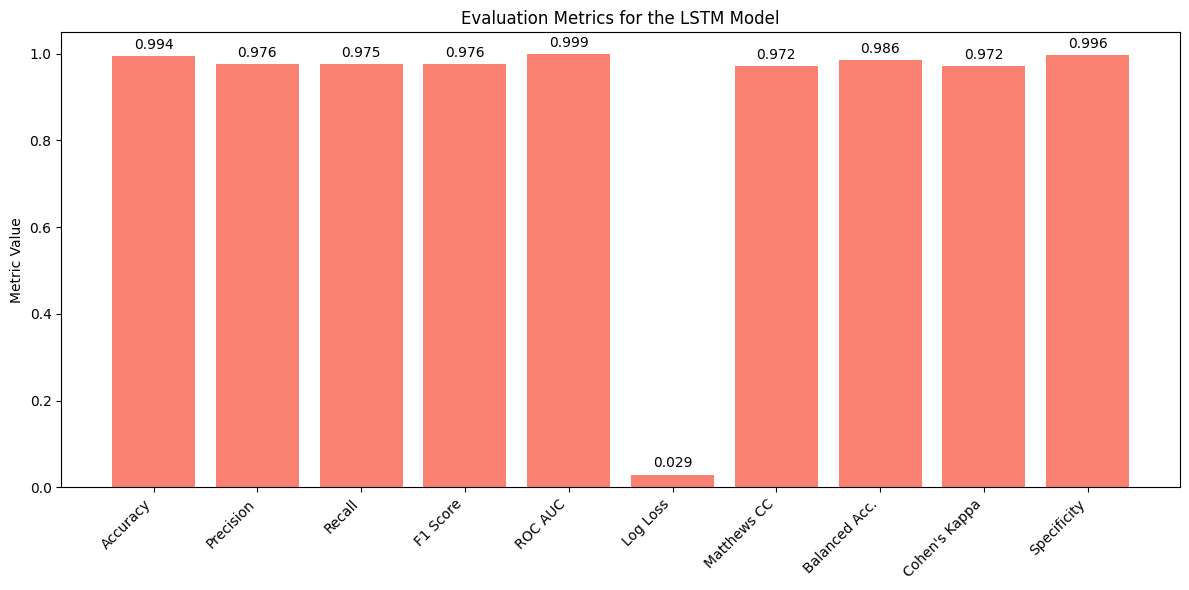

Sample 15805: Prediction: No malfunctioning
Sample 33942: Prediction: No malfunctioning
Sample 14577: Prediction: No malfunctioning
Sample 6113: Prediction: No malfunctioning
Sample 28348: Prediction: No malfunctioning
Sample 15039: Prediction: No malfunctioning
Sample 40224: Prediction: No malfunctioning
Sample 13197: Prediction: No malfunctioning
Sample 39394: Prediction: No malfunctioning
Sample 13988: Prediction: No malfunctioning
Sample 37140: Prediction: No malfunctioning
Sample 32396: Prediction: No malfunctioning
Sample 31374: Prediction: No malfunctioning
Sample 5692: Prediction: No malfunctioning
Sample 43455: Prediction: No malfunctioning
Sample 8761: Prediction: No malfunctioning
Sample 32445: Prediction: No malfunctioning
Sample 41419: Prediction: No malfunctioning
Sample 40145: Prediction: No malfunctioning
Sample 20831: DTC_NUMBER: MIL is OFF1 codes, Trouble_codes: P0133 -> Prediction: Malfunctioning
Sample 30899: Prediction: No malfunctioning
Sample 21109: DTC_NUMBER: M

In [64]:

test_loss_lstm, test_accuracy_lstm = model_lstm.evaluate(X_test_lstm, y_test)
print(f'LSTM Test Loss: {test_loss_lstm:.4f}, LSTM Test Accuracy: {test_accuracy_lstm:.4f}')

y_pred_proba_lstm = model_lstm.predict(X_test_lstm)
y_pred_lstm = (y_pred_proba_lstm >= 0.5).astype(int).flatten()

acc = accuracy_score(y_test, y_pred_lstm)
prec = precision_score(y_test, y_pred_lstm)
rec = recall_score(y_test, y_pred_lstm)
f1 = f1_score(y_test, y_pred_lstm)
roc_auc = roc_auc_score(y_test, y_pred_proba_lstm)
ll = log_loss(y_test, y_pred_proba_lstm)
mcc = matthews_corrcoef(y_test, y_pred_lstm)
bal_acc = balanced_accuracy_score(y_test, y_pred_lstm)
kappa = cohen_kappa_score(y_test, y_pred_lstm)
cm = confusion_matrix(y_test, y_pred_lstm)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp) if (tn+fp) > 0 else 0

metrics_dict_lstm = {
    "Accuracy": acc,
    "Precision": prec,
    "Recall": rec,
    "F1 Score": f1,
    "ROC AUC": roc_auc,
    "Log Loss": ll,
    "Matthews CC": mcc,
    "Balanced Acc.": bal_acc,
    "Cohen's Kappa": kappa,
    "Specificity": specificity
}

plt.figure(figsize=(12, 6))
bars = plt.bar(metrics_dict_lstm.keys(), metrics_dict_lstm.values(), color='salmon')
plt.title("Evaluation Metrics for the LSTM Model")
plt.ylabel("Metric Value")
plt.xticks(rotation=45, ha="right")
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.3f}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom')
plt.tight_layout()
plt.show()

predictions_df = meta_test.copy()
predictions_df['Predicted_Status'] = y_pred_lstm

predictions_df['Prediction'] = predictions_df['Predicted_Status'].apply(lambda x: "Malfunctioning" if x==1 else "No malfunctioning")

# Print the predictions.
for idx, row in predictions_df.iterrows():
    if row['Predicted_Status'] == 1:
        print(f"Sample {idx}: DTC_NUMBER: {row['DTC_NUMBER']}, Trouble_codes: {row['TROUBLE_CODES']} -> Prediction: Malfunctioning")
    else:
        print(f"Sample {idx}: Prediction: No malfunctioning")